In [ ]:
import os
import glob
import cv2

import pandas as pd
import numpy as np
import requests

import tensorflow as tf

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ReLU, Softmax

from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Здесь мы загрузили все пути к изображениям и маскам в переменные X и Y соответственно.
def load_data(path, split=0.1, val_split=0.1):
    X = sorted(glob(os.path.join(path, "images", "*.jpg")))
    Y = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(X) * split)
    train_x, test_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(Y, test_size=split_size, random_state=42)

    val_split_size = int(len(train_x) * val_split)
    train_x, val_x = train_test_split(train_x, test_size=val_split_size, random_state=42)
    train_y, val_y = train_test_split(train_y, test_size=val_split_size, random_state=42)

    return (train_x, train_y), (val_x, val_y), (test_x, test_y)

In [ ]:
from glob import glob
data_path = "/content/drive/MyDrive/dataset2"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_path)

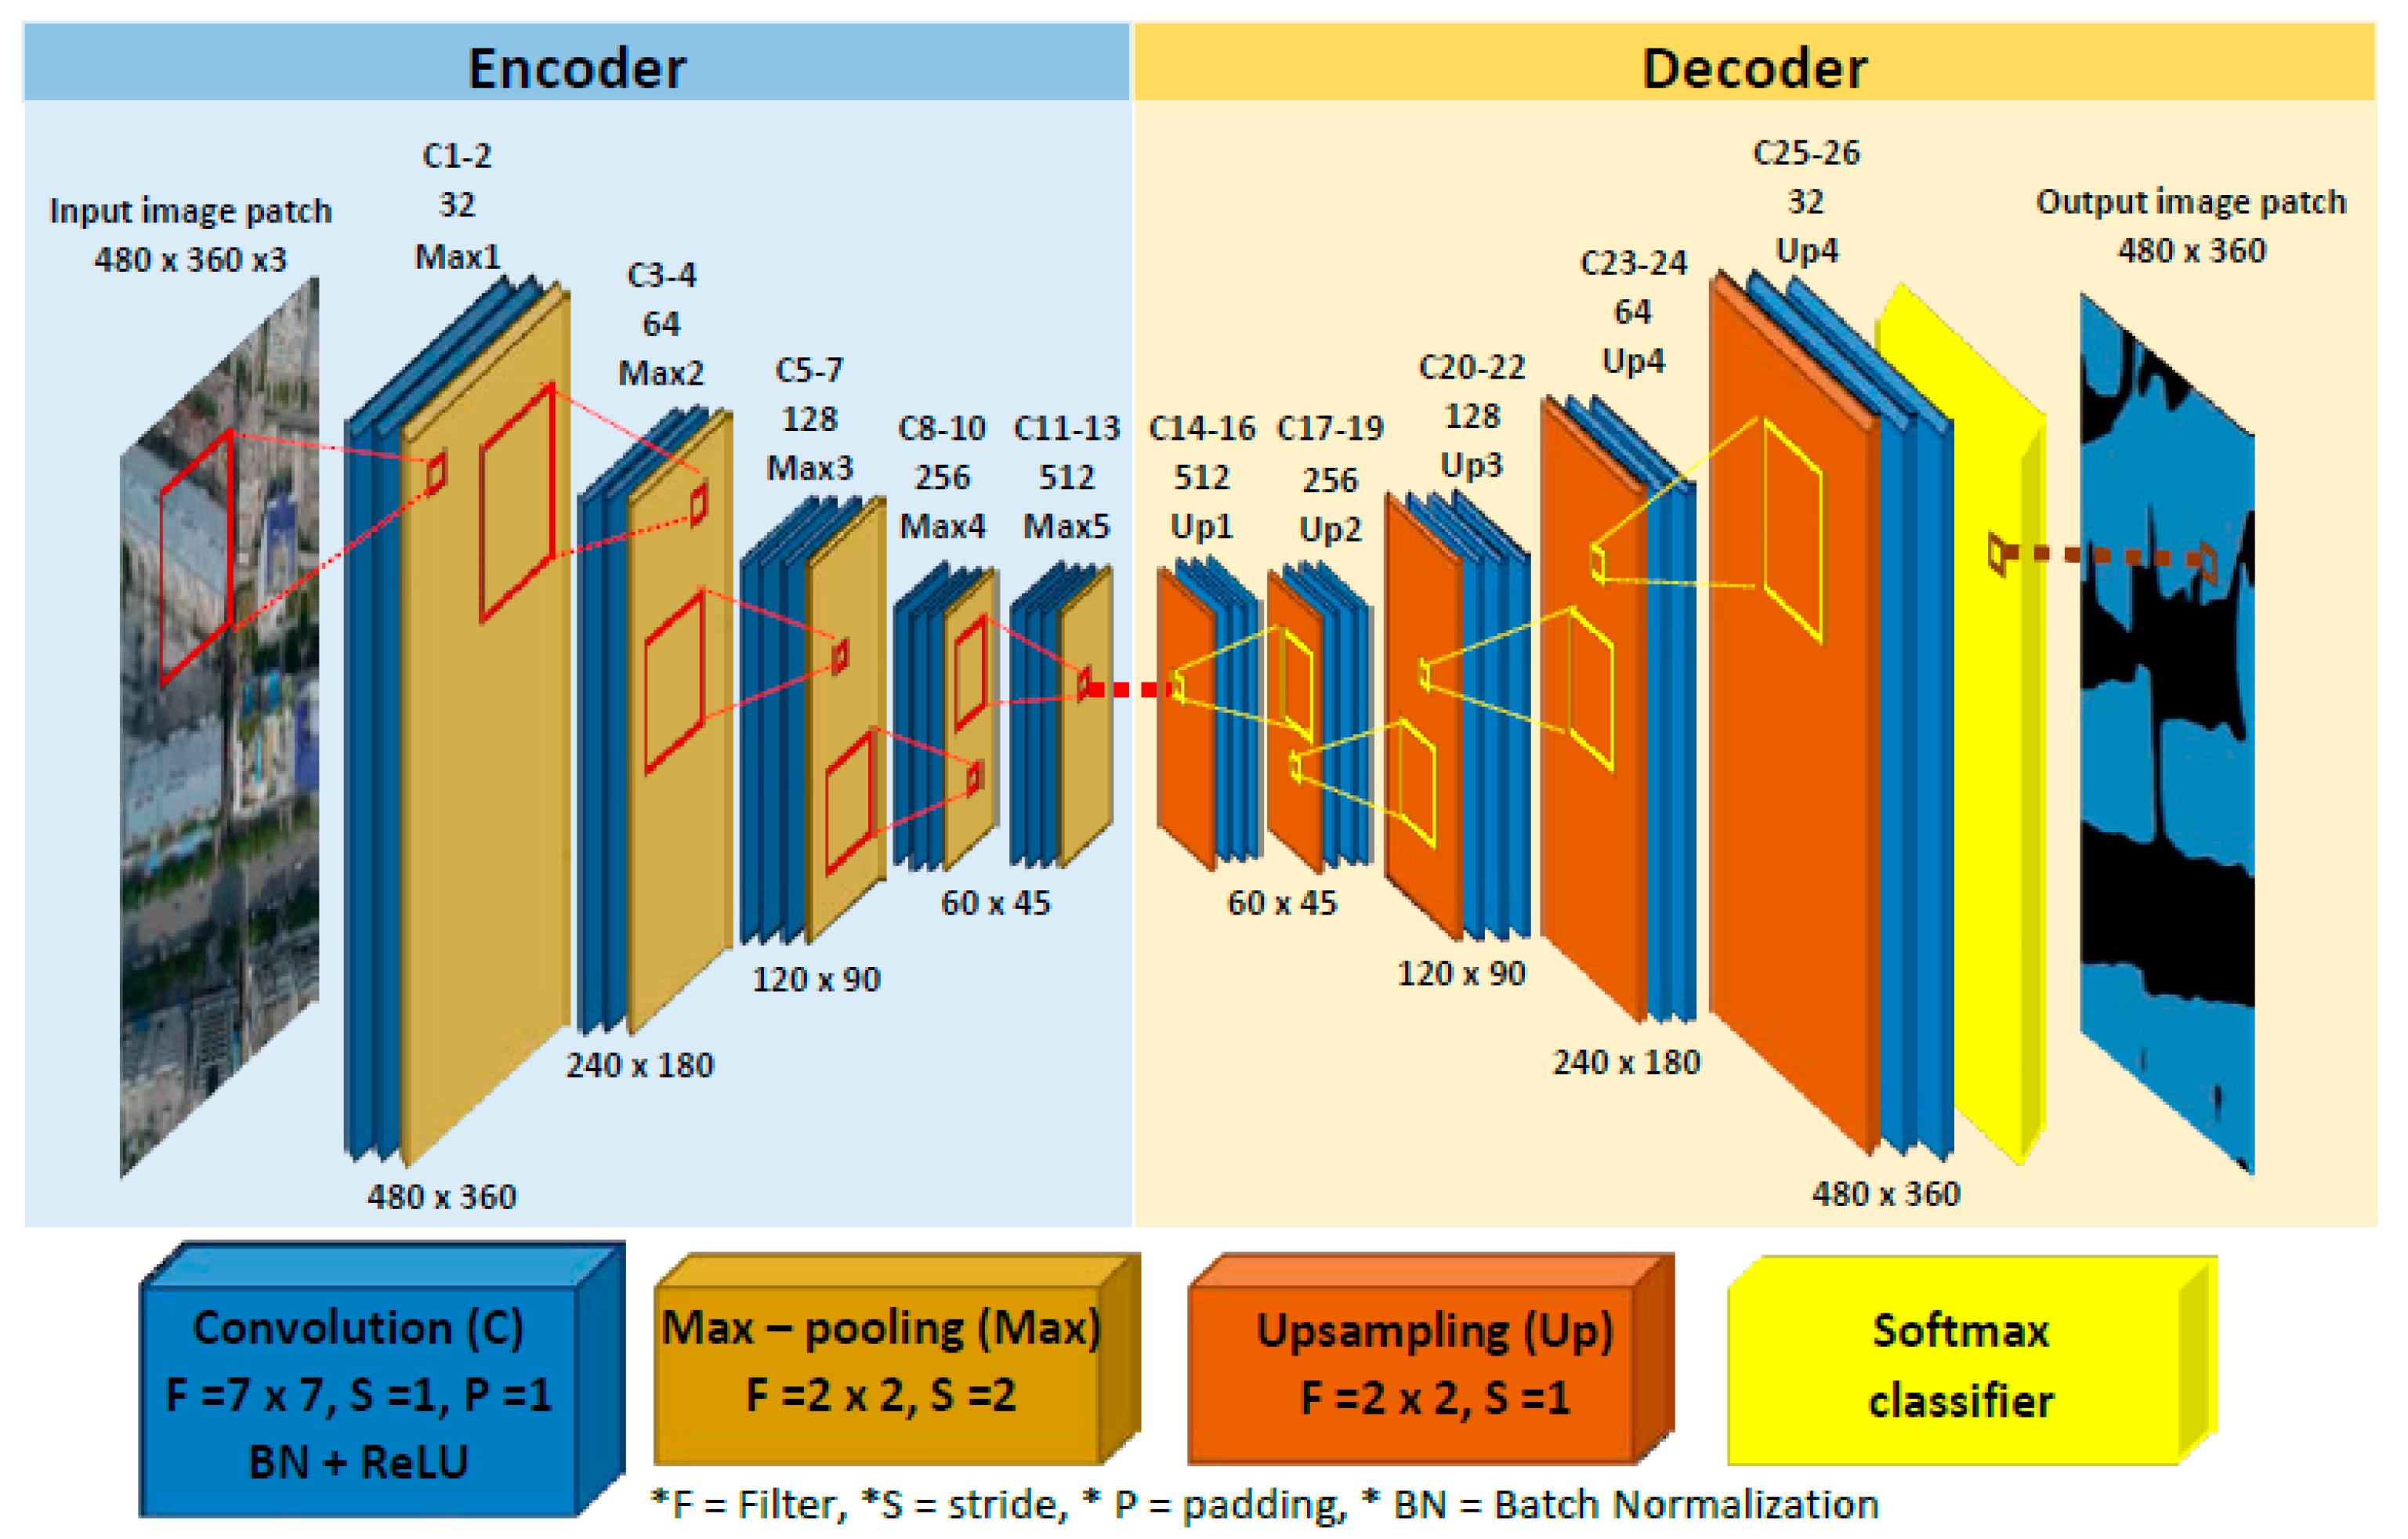

In [ ]:
def SegNet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    #ENCODER

    #1-ый блок
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)

    conv1 = Conv2D(32, (3, 3), padding='same')(relu1)
    conv1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)

    p1 = MaxPool2D((2, 2))(relu1)


    #2-ый блок
    conv2 = Conv2D(64, (3, 3), padding='same')(p1)
    conv2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)

    conv2 = Conv2D(64, (3, 3), padding='same')(relu2)
    conv2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)

    p2 = MaxPool2D((2, 2))(relu2)


    #3-й блок
    conv3 = Conv2D(128, (3, 3), padding='same')(p2)
    conv3 = BatchNormalization()(conv3)
    relu3 = ReLU()(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same')(relu3)
    conv3 = BatchNormalization()(conv3)
    relu3 = ReLU()(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same')(relu3)
    conv3 = BatchNormalization()(conv3)
    relu3 = ReLU()(conv3)

    p3 = MaxPool2D((2, 2))(relu3)


    #4-й блок
    conv4 = Conv2D(256, (3, 3), padding='same')(p3)
    conv4 = BatchNormalization()(conv4)
    relu4 = ReLU()(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same')(relu4)
    conv4 = BatchNormalization()(conv4)
    relu4 = ReLU()(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same')(relu4)
    conv4 = BatchNormalization()(conv4)
    relu4 = ReLU()(conv4)

    p4 = MaxPool2D((2, 2))(relu4)


    #5-й блок
    conv5 = Conv2D(512, (3, 3), padding='same')(p4)
    conv5 = BatchNormalization()(conv5)
    relu5 = ReLU()(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same')(relu5)
    conv5 = BatchNormalization()(conv5)
    relu5 = ReLU()(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same')(relu5)
    conv5 = BatchNormalization()(conv5)
    relu5 = ReLU()(conv5)

    p5 = MaxPool2D((2, 2))(relu5)




    #DECODER

    #1-й блок
    u1 = UpSampling2D((2,2))(p5)

    conv5 = Conv2D(512, (3, 3), padding='same')(u1)
    conv5 = BatchNormalization()(conv5)
    relu5 = ReLU()(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same')(relu5)
    conv5 = BatchNormalization()(conv5)
    relu5 = ReLU()(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same')(relu5)
    conv5 = BatchNormalization()(conv5)
    relu5 = ReLU()(conv5)


    #2-й блок

    u2 = UpSampling2D((2,2))(relu5)

    conv4 = Conv2D(256, (3, 3), padding='same')(u2)
    conv4 = BatchNormalization()(conv4)
    relu4 = ReLU()(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same')(relu4)
    conv4 = BatchNormalization()(conv4)
    relu4 = ReLU()(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same')(relu4)
    conv4 = BatchNormalization()(conv4)
    relu4 = ReLU()(conv4)


    #3-й блок

    u3 = UpSampling2D((2,2))(relu4)

    conv3 = Conv2D(128, (3, 3), padding='same')(u3)
    conv3 = BatchNormalization()(conv3)
    relu3 = ReLU()(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same')(relu3)
    conv3 = BatchNormalization()(conv3)
    relu3 = ReLU()(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same')(relu3)
    conv3 = BatchNormalization()(conv3)
    relu3 = ReLU()(conv3)


    #2-й блок

    u2 = UpSampling2D((2,2))(relu3)

    conv2 = Conv2D(64, (3, 3), padding='same')(u2)
    conv2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)

    conv2 = Conv2D(64, (3, 3), padding='same')(relu2)
    conv2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)


    #1-й блок

    u1 = UpSampling2D((2,2))(relu2)

    conv1 = Conv2D(32, (3, 3), padding='same')(u1)
    conv1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)

    conv1 = Conv2D(32, (3, 3), padding='same')(relu1)
    conv1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(relu1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice_coef = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return 1 - dice_coef

@register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
@register_keras_serializable()
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0  # Нормализация
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)  # Добавляем размерность
    return x

In [ ]:
def tf_parse(x, y):
    
    def f(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32]) #применяет функцию ф для х и у, возвращая результат преобразованный в tf.float32
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

In [ ]:
#настройка датасета
def tf_dataset(X, Y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=5000) #перемешивание
    dataset = dataset.map(tf_parse) #применение tf_parse
    dataset = dataset.batch(batch_size) #группирует элементы набора данных в батчи 
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) #данные готовятся зараннее, пока модель обучается на текущем батче
    return dataset

In [ ]:
if __name__ == "__main__":
    H = 256
    W = 256
    np.random.seed(42)
    tf.random.set_seed(42)

    create_dir("files")

    batch_size = 100
    lr = 1e-4
    num_epochs = 10
    model_path = os.path.join("files", "model.keras")
    csv_path = os.path.join("files", "data.csv")

    dataset_path = "/content/drive/MyDrive/dataset2"
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "test")

    train_x, train_y = shuffling(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y)
    valid_dataset = tf_dataset(valid_x, valid_y)

    model = SegNet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_dice_coef', mode='max'),
        ReduceLROnPlateau(monitor='val_dice_coef', factor=0.1, patience=5, min_lr=1e-7, verbose=1, mode='max'),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_dice_coef', patience=20, restore_best_weights=False, mode='max'),
    ]

    model.fit(
        train_dataset.repeat(),
        epochs=num_epochs,
        steps_per_epoch=max(1, len(train_x) // batch_size),  # Укажите количество шагов на эпоху
        validation_data=valid_dataset.repeat(),
        validation_steps=max(1, len(valid_x) // batch_size),  # Укажите количество шагов на валидацию
        callbacks=callbacks
    )

Train: 4600 - 4600
Valid: 511 - 511
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - dice_coef: 0.4874 - iou: 0.3272 - loss: 0.5126 - precision: 0.4484 - recall: 0.7007
Epoch 1: val_dice_coef improved from -inf to 0.28223, saving model to files/model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - dice_coef: 0.4887 - iou: 0.3283 - loss: 0.5113 - precision: 0.4493 - recall: 0.7022 - val_dice_coef: 0.2822 - val_iou: 0.1645 - val_loss: 0.7178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - dice_coef: 0.6146 - iou: 0.4446 - loss: 0.3854 - precision: 0.5456 - recall: 0.8030
Epoch 2: val_dice_coef did not improve from 0.28223
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 711ms/step - dice_coef: 0.6148 - iou: 0.4449 - loss: 0.3852 - precision: 0.5460 - recall: 0.8030 - val_dice_coef: 0.2096 - val_iou: 0.1171 - val_loss: 0.7904 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10

In [ ]:
save_path = os.path.join("/content/drive/MyDrive/models", "model_segnet.keras")
model.save(save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/models/model_segnet.keras


In [ ]:
from tensorflow.keras.models import load_model
custom_objects = {'dice_coef': dice_coef, 'dice_loss': dice_loss}
model_segnet = load_model(model_path, custom_objects=custom_objects)
model_segnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         147,5

 Total params: 53,979,653 (205.92 MB)

 Trainable params: 17,989,377 (68.62 MB)

 Non-trainable params: 11,520 (45.00 KB)

 Optimizer params: 35,978,756 (137.25 MB)

In [ ]:
def segment(input_path, output_name, model, background_color=(0, 0, 0)):
    cap = cv2.VideoCapture(input_path)
    frame_width, frame_height, fps = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(os.path.join("/content/drive/MyDrive/videos", f"{output_name}.mp4"), fourcc, fps, (frame_width, frame_height))

    img_size = (256, 256)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # сегментация кадра
        input_img = cv2.resize(frame, img_size) / 255.0 #нормализация
        input_img = np.expand_dims(input_img, axis=0) #добавить измерение

        mask = model.predict(input_img)[0] #предсказание
        mask = cv2.resize(mask, (frame.shape[1], frame.shape[0])) # изменяем размер маски до исходного размера изображения
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY) #преобразуем маску в бинарное изображение (0 или 255)
        mask_rgb = np.stack([mask] * 3, axis=-1) #Преобразование маски в ргб формат
        background = np.full_like(frame, background_color) #фоновое изображение с заданным цветом

        segmented_frame = np.where(mask_rgb == 255, frame, background) #Применяем маску к исходному изображению, заменяя пиксели, где маска равна 255, на исходные пиксели, а остальные на фоновый цвет
        out.write(segmented_frame)

    cap.release()
    out.release()



In [ ]:
segment("/content/drive/MyDrive/input.mp4", "segnet_video", model_segnet, (0, 0, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━